# Comparing journey times returned by Mapzen's OSRM and [Valhalla](https://mapzen.com/projects/valhalla) instances, and the Google Maps Directions API

If you'd like to run this analysis locally, install the packages from `requirements.txt`

Commit 2a64889 has the old 'dirty' version of this notebook, including route retrieval functionality 

In [1]:
import math
from lxml import etree
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import linear_model
import matplotlib as mpl
from matplotlib.collections import PatchCollection
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import json
from itertools import chain
import requests
from shapely.geometry import (
    mapping, Point, Polygon,
    LineString, MultiLineString, MultiPolygon, box)

from geojson import (
    Feature, FeatureCollection,
    LineString as gj_ls,
    MultiLineString as gj_ml,
    dumps as gj_dumps)

from shapely.ops import unary_union
import fiona
from descartes import PolygonPatch

import statsmodels
import statsmodels.formula.api as sm

from IPython.html import widgets
from IPython.html.widgets import interact
from IPython.display import display

from helpers import (
    decode_polyline,
    project_linestring,
    query_route_gmaps,
    query_route_osrm,
    query_route_valhalla,
    similarity)

from IPython.core.display import HTML

%matplotlib inline
mpl.rcParams['figure.figsize'] = (16, 12)

/Users/sth/dev/osrm_vs_valhalla/venv/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


Skip the next cell if you don't want font customisation

In [2]:
from matplotlib import rc
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Adobe Garamamond Pro']})

Skip the next cell if you don't have LaTeX installed

In [3]:
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\usepackage{sfmath}'})

The journey times and routes were retrieved by calling Mapzen's [OSRM](https://github.com/urschrei/Geopython/blob/6b504b857a736c3b011755ce44821cefdefd70bf/isochrone.ipynb) and [Valhalla](https://github.com/urschrei/Geopython/blob/master/isochrone.ipynb) instances, respectively, and by calling the Google Maps [Directions API](https://console.developers.google.com/project/london-bikeshare-routes/apiui/apiview/directions_backend/usage).  

`helpers.py` includes functions and examples for retrieving the above data into a Pandas DataFrame

Journeys were calculated from the *approximate* London Bike Share network centroid, on Westminster Bridge, to each station in the network.  
Calls to OSRM used `viaroute=bicycle`, calls to Valhalla used `{costing: bicycle}`  
No costing options were set for Valhalla or Google Maps.  

The journey times were retrieved from `['route_summary']['total_time']` for OSRM  
The journey times were retrieved from `['trip']['summary']['time']` for Valhalla  
The journey times were retrieved by summing the `duration` value for each step in each leg from `route[0]` for Google Maps.

In [4]:
routes = pd.read_csv("complete.csv", index_col=0)

####Journey origin is:

-0.12203999999842599, 51.500829999995766 (lon, lat)  
27054.81221603953, 25108.754540393566 (projected coordinates)  

`centroid_distance` is calculated using pythagoras' theorem  
`travel_time` is calculated in minutes (returned journey time / 60)

In [5]:
routes.head()

,gmaps_route,name,osrm_route,travel_time_gmaps,travel_time_osrm,travel_time_valhalla,valhalla_route,lat,lon
0,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,"River Street , Clerkenwell",osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJuDD}FGiFi...,20.666667,18.566667,17.133333,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,51.529163,-0.109971
1,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAFD~BpBNJGRWnB]...,"Phillimore Gardens, Kensington",osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJGtHI`Fm@r...,31.283333,25.950000,17.333333,isjfaBljmF}@~k@t@zOFvDGfUGzC?~DF|SOlJGtHE~Eu@t...,51.499607,-0.197574
2,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,"Christopher Street, Liverpool Street",osjfaBnhmFnCo~BJqMNc_@oAsPBsHFcJFsGZ_m@N}JeBU}...,22.183333,19.116667,19.300000,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,51.521284,-0.084606
3,ewiyHxyVsMmA{JmAmMuBUHq@lAGZtBxAGR@BFFCJgBsA{B...,"St. Chad's Street, King's Cross",osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJuDD}FGiFi...,22.550000,18.916667,16.233333,isjfaBljmFfCi`CNqMNc_@sAsPFuHDcJFsG\}l@?kCNuFu...,51.530059,-0.120974
4,ewiyHxyVt_@rDjJlAfBp@vFbE^\tAjCDHBNCHE@CH@D|Dv...,"Sedding Street, Sloane Square",osjfaBnhmFu@xm@p@zOHvDKhUAzCE`EHzSMjJGtHI`Fm@r...,19.800000,13.533333,10.950000,isjfaBljmF}@~k@t@zOFvDGfUGzC?~DF|SOlJGtHE~Eu@t...,51.493130,-0.156876


Cluster journeys using k-means++

(This isn't terribly enlightening, it turns out)

## Visualising Differences in Route Geography

As a next step, we're going to visualise the different routes returned by Valhalla and OSRM. In order to do this, we need to decode the polyline-encoded route strings, collect these, and map them.

We'll need the `Basemap` matplotlib extension in order to create these static maps.

In [6]:
for provider in ['osrm', 'valhalla', 'gmaps']:
    if provider == 'gmaps':
        routes['%s_decoded' % provider] = routes.apply(
            lambda f: decode_polyline(f['%s_route' % provider], gmaps=True), axis=1)
    else:
        routes['%s_decoded' % provider] = routes.apply(
            lambda f: decode_polyline(f['%s_route' % provider]), axis=1)

Now set up a map, and project our routes into map coordinates

In [7]:
bds = MultiLineString(list(routes['valhalla_decoded'])).bounds
extra = 0.01
ll = (bds[0], bds[1])
ur = (bds[2], bds[3])
coords = list(chain(ll, ur))
w, h = coords[2] - coords[0], coords[3] - coords[1]

In [8]:
m = Basemap(
    projection='tmerc',
    lon_0 = -0.12203999999842599,
    lat_0 = 51.500829999995766,
    ellps = 'WGS84',
    llcrnrlon=coords[0] - extra * w,
    llcrnrlat=coords[1] - extra + 0.01 * h,
    urcrnrlon=coords[2] + extra * w,
    urcrnrlat=coords[3] + extra + 0.01 * h,
    resolution='i',
    suppress_ticks=True)

We can now create the projected versions of our routes, and combine each provider's routes into a MultiLineString

In [9]:
# first, calculate projected coordinates and centroid distance using our Basemap instance
centroid = m(-0.12204, 51.50083)

routes['projected_lon'], routes['projected_lat'] = m(
    *(routes["lon"].values, routes["lat"].values))

routes['centroid_distance'] = routes.apply(
    lambda x: math.sqrt(((abs(centroid[0] - x['projected_lon']) ** 2) +
                         (abs(centroid[1] - x['projected_lat']) ** 2))), axis=1)
combined_routes = {}
for provider in ['osrm', 'valhalla', 'gmaps']:
    # create projected version of routes
    routes['%s_decoded_proj' % provider] = routes.apply(
        lambda f: project_linestring(f['%s_decoded' % provider], m), axis=1)
    # combine projected route LineStrings
    combined_routes[provider] = MultiLineString(list(routes['%s_decoded_proj' % provider]))
    # we can also calculate the projected route distances (as opposed to euclidean distance, as above)
    routes['%s_route_length_proj' % provider] = routes.apply(
        lambda f: f['%s_decoded_proj' % provider].length / 1000, axis=1)

Let's carry out some regressions in order to determine time/great-circle route distance correlation

In [10]:
# OSRM regression
regressions = []
for provider in ['osrm', 'valhalla', 'gmaps']:
    regressions.append(
        sm.ols(formula='%s_route_length_proj ~ travel_time_%s' % (provider, provider),
        data=routes).fit())

for res in regressions:
    print res.summary2()

                     Results: Ordinary least squares
Model:              OLS                    Adj. R-squared:     0.997    
Dependent Variable: osrm_route_length_proj AIC:                -944.7353
Date:               2015-08-13 00:17       BIC:                -935.6048
No. Observations:   710                    Log-Likelihood:     474.37   
Df Model:           1                      F-statistic:        2.453e+05
Df Residuals:       708                    Prob (F-statistic): 0.00     
R-squared:          0.997                  Scale:              0.015432 
-------------------------------------------------------------------------
                     Coef.   Std.Err.     t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------------
Intercept           -0.1292    0.0112  -11.5699  0.0000  -0.1511  -0.1073
travel_time_osrm     0.2304    0.0005  495.3078  0.0000   0.2295   0.2313
------------------------------------------------------------------

The OSRM journeys look almost perfectly correlated, whereas the Valhalla journeys don't.

**WHAT IS GOING ON WITH GOOGLE MAPS THOUGH**

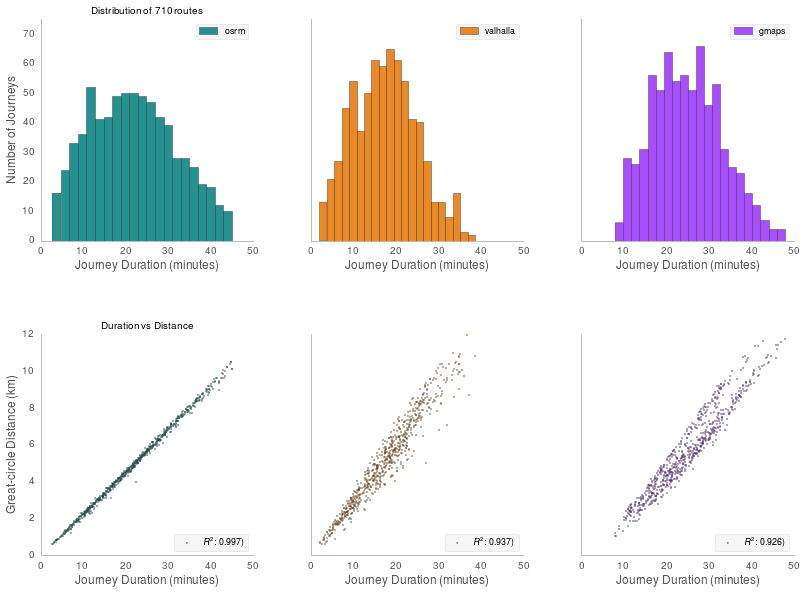

In [11]:
dotsize = 2.
linewidth = .5
fontsize = 12

plt.clf()
fig = plt.figure(figsize=(7.28, 5.25))

# define a grid of subplots
axes = [
    plt.subplot2grid((2, 3), (0, 0)),
    plt.subplot2grid((2, 3), (0, 1)),
    plt.subplot2grid((2, 3), (0, 2)),
    plt.subplot2grid((2, 3), (1, 0)),
    plt.subplot2grid((2, 3), (1, 1)),
    plt.subplot2grid((2, 3), (1, 2))
    ]

colours = ["#008080", "#E87600", "#9B30FF"]
# TODO sharex / sharey
for idx, provider in enumerate(['osrm', 'valhalla', 'gmaps']):
    ax = axes[idx]
    hist = routes['travel_time_%s' % provider].plot(
        ax=ax,
        kind='hist',
        color=colours[idx],
        edgecolor='#333333',
        bins=21,
        alpha=0.85,
        legend=True)

    ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
    ax.set_ylabel('Number of Journeys', fontsize=fontsize)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 75)
    leg = ax.legend(["%s" % provider], fontsize=9)
    leg.get_frame().set_alpha(0.5)
    ax.grid(b=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axis_bgcolor('none')
    
    if idx != 0:
        ax.set_yticklabels([])
        ax.set_ylabel('')

for idx, provider in enumerate(['osrm', 'valhalla', 'gmaps']):
    ax = axes[idx + 3]
    osrm_cluster = ax.scatter(
        x=routes['travel_time_%s' % provider],
        y=routes['%s_route_length_proj' % provider],
        marker='o',
        color=colours[idx],
        edgecolor='#333333',
        lw=linewidth,
        s=dotsize,
        alpha=0.55,)

    ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
    ax.set_ylabel('Great-circle Distance (km)', fontsize=fontsize)
    ax.grid(b=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_axis_bgcolor('none')
    leg = ax.legend(
        [r'$R^2$: %0.3f)' % (regressions[idx].rsquared)],
        scatterpoints=1,
        loc='lower right',
        fontsize=9)
    leg.get_frame().set_alpha(0.5)
    ax.set_xlim(0, 50)
    ax.set_ylim(0, 12)
    if idx + 3 != 3:
        ax.set_yticklabels([])
        ax.set_ylabel('')

axes[0].set_title('Distribution of %s routes' % len(routes), fontsize=10)
axes[3].set_title('Duration vs Distance', fontsize=10)
        
        
# Save etc
plt.tight_layout()
fig.set_size_inches(12, 9)
plt.savefig(
    'combined.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=300)

plt.show()

As is obvious from the histograms, the journey times and their distribution vary significantly between the three routers; Valhalla thinks you can get to any station in just over 35 minutes, with the majority taking 15–20 minutes. OSRM's journey times are far more evenly distributed, and greater in duration. [Most](https://twitter.com/mapzen/status/626080158890479620) (though [not all](https://twitter.com/mapzen/status/626083924192690176)) of the variation in duration is explained by Valhalla's default cycle speed of **25kph**, versus OSRM's **15kph**. When cycling speed and other costing options become available in the API, it'll be much easier to make more nuanced comparisons.

An R-squared of **.997** implies almost-perfect correlation, in the case of OSRM.  
R-squared values of **.937** (Valhalla) and **.926** (Google Maps) imply high correlation, but there are clearly some factors we aren't taking into account.  

Some possible conclusions:

- The costs assigned by OSRM do not seem to vary with journey length, or any other measure (elevation, number of turns, traffic lights etc.)
- By comparison, Valhalla and Google Maps do seem to be assigning costs in a different way according to certain route characteristics
    - Based on variation of returned routes, Google Maps is using live data (perhaps traffic) as a factor when determining an optimal route

We can also do some clustering, though this isn't terribly informative, as it turns out

In [12]:
centroids = {}
for provider in ['osrm', 'valhalla', 'gmaps']:
    km = KMeans(init='k-means++', n_clusters=7, n_init=10)
    km.fit(routes[['centroid_distance', 'travel_time_%s' % provider]])
    routes['kmeans_bin_%s' % provider] = km.labels_
    centroids[provider] = km.cluster_centers_

We can also calculate the percentage of route segments each route has in common

In [14]:
routes['osrm_valhalla_similarity'] = routes.apply(
    lambda f: similarity(f['osrm_decoded'], f['valhalla_decoded']), axis=1)

routes['osrm_gmaps_similarity'] = routes.apply(
    lambda f: similarity(f['osrm_decoded'], f['gmaps_decoded']), axis=1)

routes['valhalla_gmaps_similarity'] = routes.apply(
    lambda f: similarity(f['valhalla_decoded'], f['gmaps_decoded']), axis=1)

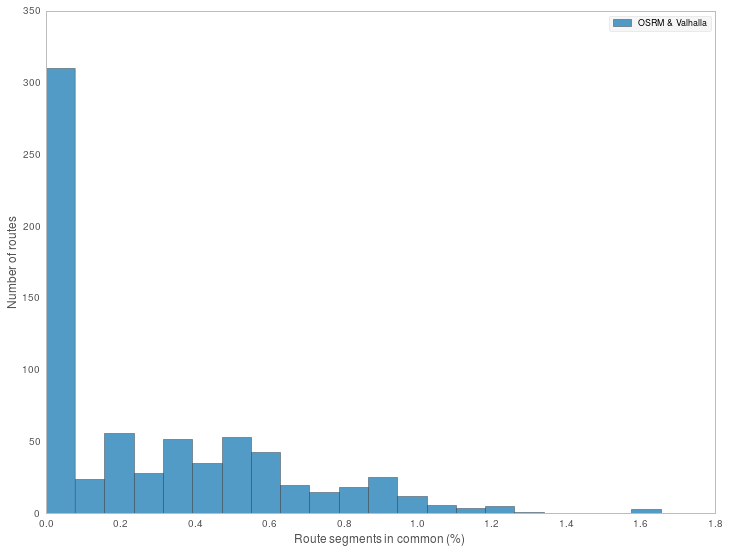

In [15]:
plt.clf()
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111)

routes['osrm_valhalla_similarity'].plot(
        ax=ax,
        kind='hist',
        edgecolor='#333333',
        bins=21,
        alpha=0.85,
        legend=True)

ax.set_xlabel('Route segments in common (\%)', fontsize=fontsize)
ax.set_ylabel('Number of routes', fontsize=fontsize)
leg = ax.legend(["OSRM \& Valhalla"], fontsize=9)
leg.get_frame().set_alpha(0.5)
ax.grid(b=False)
ax.set_axis_bgcolor('none')

plt.show()

### Outlier detection on the Valhalla data using [RANSAC](https://en.wikipedia.org/wiki/RANSAC)

In [14]:
time_reshaped = np.reshape(
    routes['travel_time_valhalla'], (len(routes['travel_time_valhalla']), 1))
route_reshaped = np.reshape(
    routes['valhalla_route_length_proj'], (len(routes['valhalla_route_length_proj']),))

In [21]:
model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression(), max_trials=1000)
res = model_ransac.fit(time_reshaped, route_reshaped)
inlier_mask = model_ransac.inlier_mask_
outlier_mask = np.logical_not(inlier_mask)

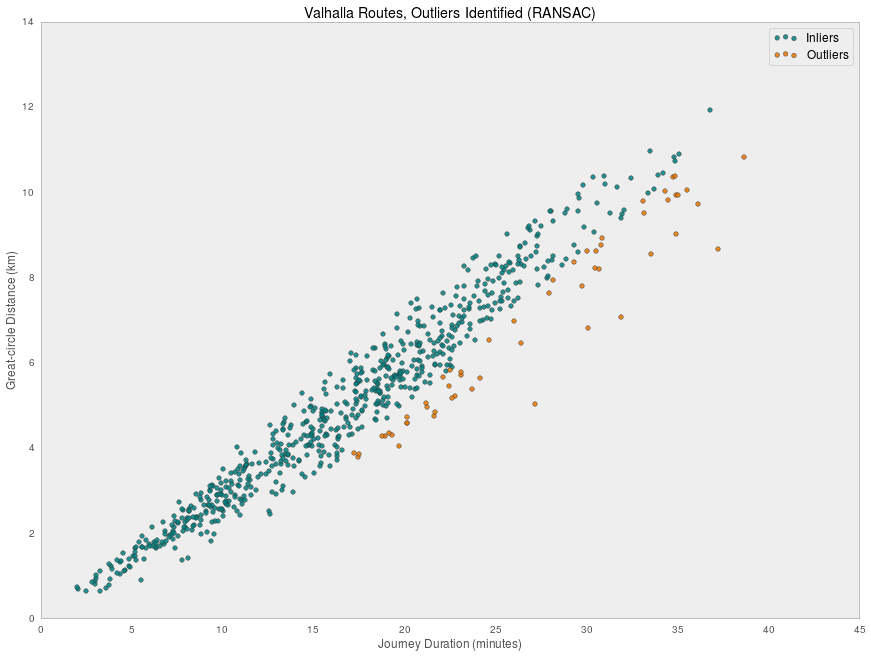

In [23]:
plt.clf()
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)

plt.scatter(
    time_reshaped[inlier_mask], route_reshaped[inlier_mask],
    color="#008080",
    label='Inliers',
    marker='o',
    edgecolor='#333333',
    alpha=.85)

plt.scatter(
    time_reshaped[outlier_mask], route_reshaped[outlier_mask],
    color="#E87600",
    label='Outliers',
    marker='o',
    edgecolor='#333333',
    alpha=.85)

ax.set_xlabel('Journey Duration (minutes)', fontsize=fontsize)
ax.set_ylabel('Great-circle Distance (km)', fontsize=fontsize)
plt.title("Valhalla Routes, Outliers Identified (RANSAC)")

plt.legend()
plt.tight_layout()
fig.set_size_inches(12, 9)
plt.savefig(
    'RANSAC.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=72)
plt.show()

Using the resulting 'mask' arrays, we can see the outlier destinations, and how long Google thinks it should take

In [24]:
routes.loc[outlier_mask][['name', 'valhalla_route_length_proj', 'gmaps_route_length_proj']]

,name,valhalla_route_length_proj,gmaps_route_length_proj
2,"Christopher Street, Liverpool Street",4.300234,4.783215
27,"Leonard Circus , Shoreditch",4.581616,5.394967
34,"Sun Street, Liverpool Street",4.268401,4.522409
46,"Finsbury Circus, Liverpool Street",3.783770,4.097179
49,"New Inn Yard, Shoreditch",4.951017,5.774126
58,"Calshot Street , King's Cross",5.457297,5.374588
73,"Devonshire Square, Liverpool Street",4.048998,4.558589
105,"Norton Folgate, Liverpool Street",4.738417,4.920809
114,"Bethnal Green Road, Shoreditch",5.208709,6.270738
120,"Finsbury Square , Moorgate",4.274586,4.753984


And map them…

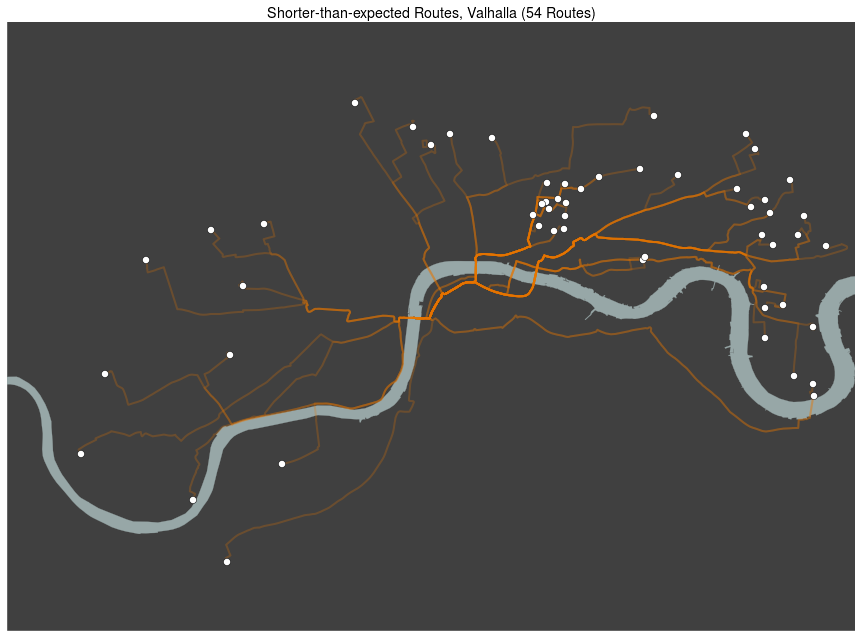

In [25]:
plt.clf()
fig = plt.figure(figsize=(16, 12), dpi=300)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

m.fillcontinents('#404040')
m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

pc_valhalla = PatchCollection(
    [PolygonPatch(
        line.buffer(20)) for line in MultiLineString(
            list(routes.loc[outlier_mask]['valhalla_decoded_proj']))],
    match_original=False, alpha=.25, color="#E87600", lw=.001, zorder=4)
pc_valhalla.set_label("valhalla")
ax.add_collection(pc_valhalla)

m.scatter(
    routes.loc[outlier_mask]['projected_lon'],
    routes.loc[outlier_mask]['projected_lat'],
    s=50,
    color='#ffffff',
    edgecolor='#000000',
    ax=ax,
    zorder=4)

thames = m.readshapefile(
    'thames_wgs84',
    'thames',
    color='none',
    zorder=4)
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#97a7a7', lw=.25, alpha=1., zorder=3)
ax.add_collection(tp)
plt.title("Shorter-than-expected Routes, Valhalla (%s Routes)" % len(routes.loc[outlier_mask]))

plt.tight_layout()
fig.set_size_inches(12, 9)
plt.savefig(
    'outliers_mapped.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=72)

plt.show()

## Visualising all routes on a map

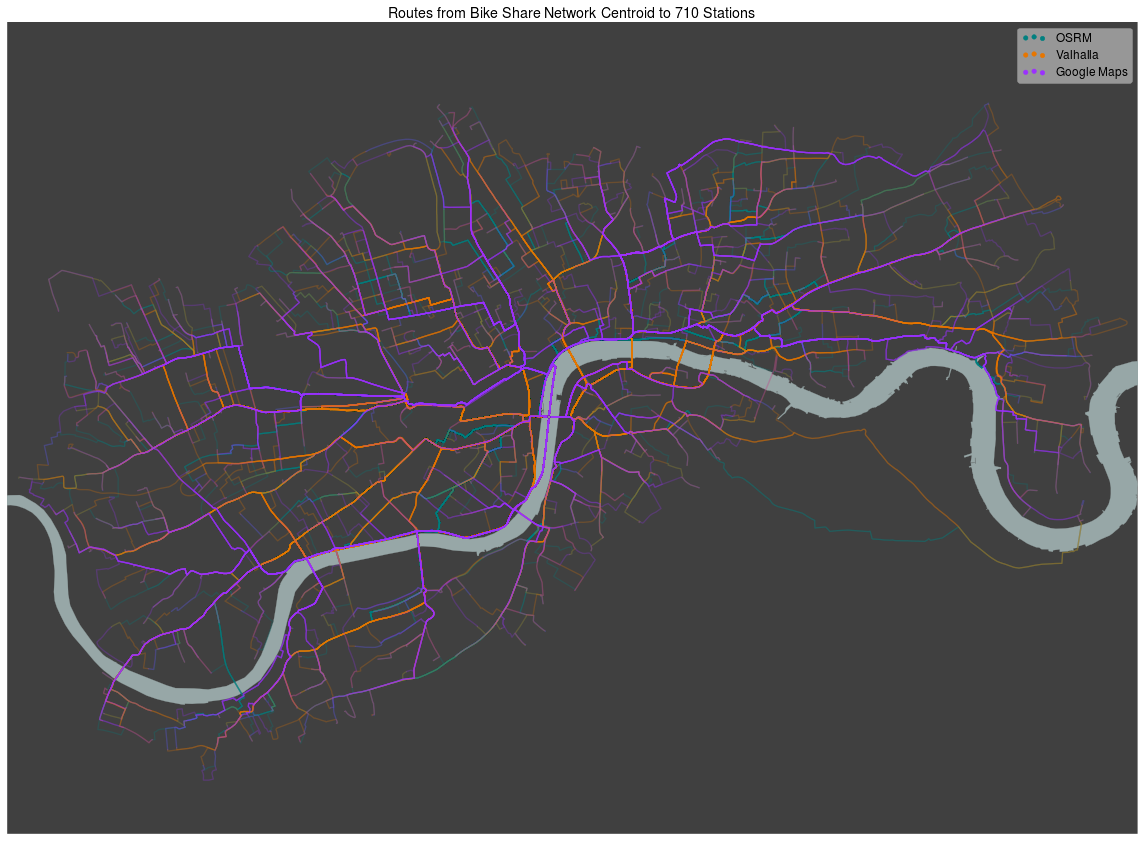

None

In [29]:
plt.clf()
fig = plt.figure(figsize=(16, 12), dpi=300)
ax = fig.add_subplot(111, axisbg='w', frame_on=False)

m.fillcontinents('#404040')
m.drawparallels(
    np.arange(ll[0], ur[0], 2.),
    color = 'black', linewidth = 0.5,
    labels=[True, False, False, False], ax=ax)
m.drawmeridians(
    np.arange(ll[1], ur[1], 2.),
    color = 'black', linewidth = 0.5,
    labels=[False, False, False, True], ax=ax)

# set up our route patch collections
patchcollections = {}
for provider, colour in [("osrm", "#008080"), ("valhalla", "#E87600"), ("gmaps", "#9B30FF")]:
    pc = PatchCollection([PolygonPatch(
    line.buffer(10)) for line in combined_routes[provider]],
    match_original=False, alpha=.25, color=colour, lw=.001, zorder=4)
    pc.set_label(provider)
    patchcollections[provider] = pc
    # ax.add_collection(pc)

# cascade Thames polygons together, and plot
thames = m.readshapefile(
    'thames_wgs84',
    'thames',
    color='none',
    zorder=4)
thames_poly = unary_union([Polygon(xy) for xy in m.thames])
tp = PatchCollection(
    [PolygonPatch(poly) for poly in thames_poly],
    match_original=False,
    color='#97a7a7', lw=.25, alpha=1., zorder=3)
ax.add_collection(tp)

# add centroid
centroid = m(-0.12204, 51.50083)
m.scatter(*centroid,
    s=5., edgecolor='#000000', alpha=1.,
    color='w', zorder=5)

# fake a legend. Tsk
lt = m.scatter([], [], color="#008080")
lo = m.scatter([], [], color="#E87600")
lg = m.scatter([], [], color="#9B30FF")

labels = ["OSRM", "Valhalla", "Google Maps"]
leg = plt.legend([lt, lo, lg], labels)
leg.get_frame().set_alpha(0.5)

plt.title("Routes from Bike Share Network Centroid to %s Stations" % len(routes))
plt.tight_layout()
plt.savefig('routes.png', dpi=300, bbox_inches='tight', alpha=True, transparent=True)

# convenience functions for adding and removing PatchCollections 
def remove_patches(ax, label):
    """ find and remove a PatchCollection by name """
    for idx, pc in enumerate(ax.collections):
        if pc.get_label() == label:
            ax.collections.pop(idx)

def display_osrm(OSRM):
    """ Display or remove OSRM layer according to boolean input """
    if OSRM:
        ax.add_collection(patchcollections['osrm'])
    else:
        remove_patches(ax, "osrm")
    display(fig)            

def display_valhalla(Valhalla):
    """ Display or remove Valhalla layer according to boolean input """
    if Valhalla:
        ax.add_collection(patchcollections['valhalla'])
    else:
        remove_patches(ax, "valhalla")
    display(fig)
    
def display_gmaps(GMaps):
    """ Display or remove GMaps layer according to boolean input """
    if GMaps:
        ax.add_collection(patchcollections['gmaps'])
    else:
        remove_patches(ax, "gmaps")
    display(fig)

plt.close(fig)
interact(display_osrm, OSRM=True)
interact(display_valhalla, Valhalla=True)
interact(display_gmaps, GMaps=True)

plt.show()

In [108]:
plt.savefig(
    'mpl_map.png',
    format="png",
    bbox_inches='tight',
    alpha=True,
    transparent=True,
    dpi=300)

## Outputting our decoded Polyline journeys to GeoJSON

Dumping to GeoJSON is straightforward.  

- import `geojson`
- encode each LineString as a Feature
- wrap the list of Features in a FeatureCollection
- dump the FeatureCollection as a JSON string

In [55]:
for provider in ['osrm', 'valhalla', 'gmaps']:
    with open('html/%s_geojson.json' % provider, 'w') as f:
        f.write(gj_dumps(FeatureCollection(
            [Feature(geometry=feat) for feat in list(routes['%s_decoded' % provider])])))

In [130]:
def route_valhalla(df, start):
    return query_route_valhalla(api_key, start, (df['lon'], df['lat']), 'bicycle')

def route_gmaps(df, start):
    return query_route_gmaps(start, (df['lon'], df['lat']), 'bicycling', gmaps_key)

def route_osrm(df, start):
    return query_route_osrm(start, (df['lon'], df['lat']), 'bicycle')

In [57]:
# Get updated stations from TfL XML
# parse XML into dict
tree = etree.parse("livecyclehireupdates.xml")
root = tree.getroot()

output = dict()
output['name'] = []
output['lon'] = []
output['lat'] = []

for each in root.xpath('station'):
    output['name'].append(each[1].text)
    output['lon'].append(each[4].text)
    output['lat'].append(each[3].text)

stations = pd.DataFrame(output)
stations[['lon', 'lat']] = stations[['lon', 'lat']].astype(float)

In [58]:
len(stations)

737

In [59]:
# we only want to keep stations NOT IN our route dataframe
stations = stations[-stations['name'].isin(routes['name'])]
len(stations)

27

There is no route available to each of the following stations from one or more OpenStreetMap routers

In [82]:
def table_gen(header_text, iterable):
    """ Incredibly hacky Markdown table generator """
    header = "|{f} ({g} stations)|\n:---------:\n".format(f=header_text, g=len(iterable))
    row = ("|{t}|".format(t=text) for text in iterable)
    return header + "\n".join(row)

In [83]:
print table_gen("Station Name", stations['name'])

|Station Name (27 stations)|
:---------:
|Belgrove Street , King's Cross|
|Finsbury Library , Finsbury|
|Euston Road, Euston|
|Park Road (Baker Street), The Regent's Park|
|Wapping High Street, Wapping|
|Clerkenwell Green, Clerkenwell|
|Waterloo Place, St. James's|
|Baylis Road, Waterloo|
|Craven Street, Strand|
|Prince Consort Road, Knightsbridge|
|Waterloo Station 1, Waterloo|
|Paddington Green Police Station, Paddington|
|Old Ford Road, Bethnal Green|
|South Quay East, Canary Wharf|
|Westferry DLR, Limehouse|
|Jubilee Plaza, Canary Wharf|
|Green Park Station, Mayfair|
|East India DLR, Blackwall|
|Montgomery Square, Canary Wharf|
|Heron Quays DLR, Canary Wharf|
|Westfield Southern Terrace ,Shepherd's Bush|
|Globe Town Market, Bethnal Green|
|Coomer Place, West Kensington|
|West Kensington Station, West Kensington|
|Ravenscourt Park Station, Hammersmith|
|Stephendale Road, Sands End|
|Rossmore Road, Marylebone|


## Begin to retrieve missing stations from our routers

In [395]:
stations['travel_time_gmaps'], stations['gmaps_route'] = zip(*
    stations.apply(route_gmaps, args=((-0.12203999999842599, 51.500829999995766),), axis=1))

stations = stations.dropna()
len(stations)

27

In [264]:
stations['travel_time_osrm'], stations['osrm_route'] = zip(*
    stations.apply(route_osrm, args=((-0.12203999999842599, 51.500829999995766),), axis=1))

stations = stations.dropna()
len(stations)

12

In [281]:
stations['travel_time_valhalla'], stations['valhalla_route'] = zip(*
    stations.apply(route_valhalla, args=((-0.12203999999842599, 51.500829999995766),), axis=1))

stations = stations.dropna()
len(stations)

0

In [212]:
stations['travel_time_valhalla'] = stations['travel_time_valhalla'] / 60
stations['travel_time_osrm'] = stations['travel_time_osrm'] / 60
stations['travel_time_gmaps'] = stations['travel_time_gmaps'] / 60

In [397]:
centroid = m(-0.12204, 51.50083)

stations['projected_lon'], stations['projected_lat'] = m(*(stations["lon"].values, stations["lat"].values))
stations['centroid_distance'] = stations.apply(
    lambda x: math.sqrt(((abs(centroid[0] - x['projected_lon']) ** 2) +
                         (abs(centroid[1] - x['projected_lat']) ** 2))), axis=1)

In [225]:
routes = pd.concat(
    [routes, stations],
    ignore_index=True
)